In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as sm_stats
from itertools import compress
from kneed import KneeLocator
import random
from tqdm import tqdm
import scipy as sp
from scipy.cluster.hierarchy import linkage, leaves_list
import anndata

In [2]:
random.seed(3)

In [3]:
adata_dir = 'adata_env'

adata = sc.read('adata_integrated.h5ad')
patients = adata.obs['patient'].cat.categories

env_names = adata.obs.columns[['env_' in el for el in adata.obs.columns]]
env_names = [e for e in env_names if 'MT' not in e]

rctd_names = adata.obs.columns[['rctd_' in el for el in adata.obs.columns]]
rctd_names = [r for r in rctd_names if 'Mast' not in r]

sigs = env_names

In [4]:
# remove outlier sample
keep = [all([s not in patient for s in ['313']]) for patient in patients]
patients = list(compress(patients, keep))
adata = adata[adata.obs['patient'].isin(patients)]

# define niches

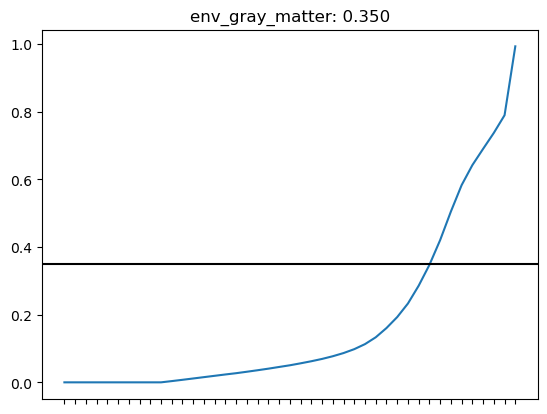

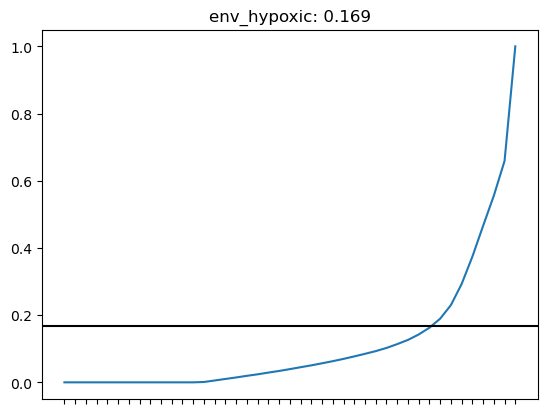

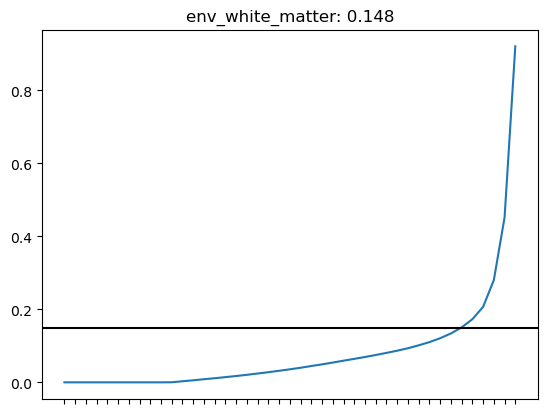

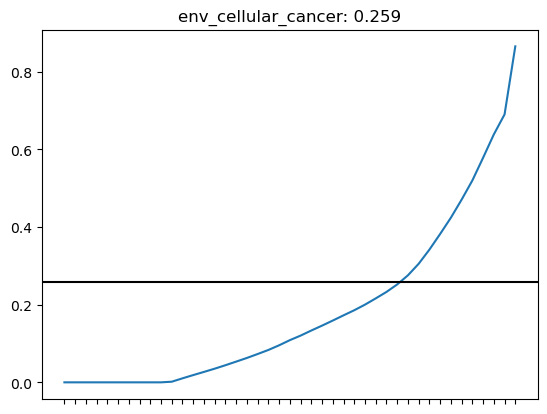

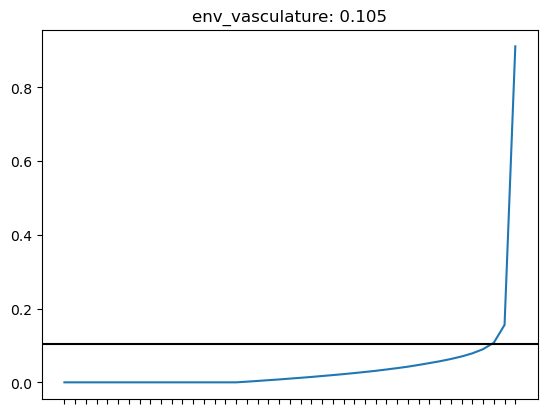

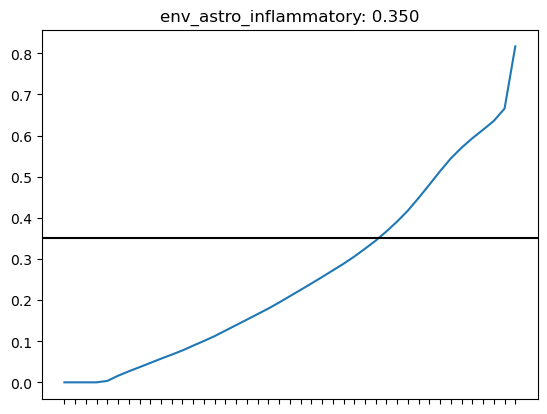

In [5]:
# for all patients but plot one
niches = pd.DataFrame(index=adata.obs.index, columns=sigs, dtype='bool')

for i,s in enumerate(sigs):
    e = adata.obs[s]
    se = e.sort_values(ascending=True)

    kneedle = KneeLocator(range(len(se)), se, S=8, curve="convex", direction="increasing")
    ethr = round(kneedle.elbow_y,3)
    if 'inflammatory' in s:
        ethr = 0.35
    if 'gray' in s:
        ethr = 0.35
    
    niches.loc[:,s] = e>ethr

    #kneedle.plot_knee()
    plt.figure()
    plt.plot(se[::1000])
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.title('%s: %.3f'%(s,ethr))
    plt.axhline(ethr,c='black')

In [6]:
niche_proportions = pd.DataFrame(0, index=sigs, columns=patients)

for p in patients:
    patient_niches = niches[adata.obs['patient']==p]
    niche_proportions.loc[:,p] = patient_niches.sum(axis=0)/patient_niches.shape[0]

# inter-pixel spatial enrichment regression per patient

In [7]:
def spatial_mean(W,q):
    
    if sp.sparse.issparse(W):
        Wtrue = np.where((W>0).todense())[1]
    else:
        Wtrue = np.where(W>0)[1]
    Wpos = np.unique(Wtrue)
    
    return q[Wpos].mean()

In [8]:
def regress_enrichment(y,x1):
    x = sm.add_constant(x1)
    res = sm.OLS(y,x).fit()
                    
    return (res.params[1])/res.params[0], res.pvalues[1]

In [9]:
# set distance
r = 1

# initialize dfs
index = pd.MultiIndex.from_product([sigs,sigs])
X = pd.DataFrame(np.nan, index= index, columns=patients)
X = X.sort_index()
P = X.copy()
Padj = X.copy()

# measure spatial enrichment, asymmetric
l = len(sigs)
for p in tqdm(patients):
    _adata = adata[adata.obs['patient']==p,:]

    d = _adata.obsp['spatial_distances'].todense()
    d[d==0] = np.nan
    d[np.eye(d.shape[0])==1] = 0

    W =  d<=r

    patient_niches = niches[adata.obs['patient']==p]

    # populate matrix
    for i in range(l):
        s1 = sigs[i]
        prog = _adata.obs[s1]
        
        # calculate mean of disk of radius r centered on every pixel
        smeans = np.array([spatial_mean(w,prog) for w in W])
        
        # regresss enrichment
        for j in range(l):
            s2 = sigs[j]
            # skip if niche makes up less than 0.1% (absent) of sample or more than 99% (everywhere)
            if niche_proportions.loc[s2,p]>0.001 and niche_proportions.loc[s2,p]<0.99:  
                X.loc[(s1,s2),p], P.loc[(s1,s2),p] = regress_enrichment(smeans, patient_niches[s2]*1)
                
# calculate Padj
for patient in P.columns:
    Padj[patient].loc[P[patient].dropna().index] = \
        sm_stats.multitest.multipletests(pvals = P[patient].dropna(), method='fdr_bh')[1]
    
logP = -np.log10(Padj)
maxlogP = logP.replace(np.inf, np.nan).max().max()
logP.replace(np.inf, maxlogP+1, inplace=True)

100%|███████████████████████████████████████████| 14/14 [00:37<00:00,  2.64s/it]
/Users/cpc45/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


In [10]:
X.to_csv('spatial_enrichment_regression_r%i_env.csv'%r)
logP.to_csv('spatial_enrichment_regression_r%i_logPadj_env.csv'%r)

/Users/cpc45/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/cpc45/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


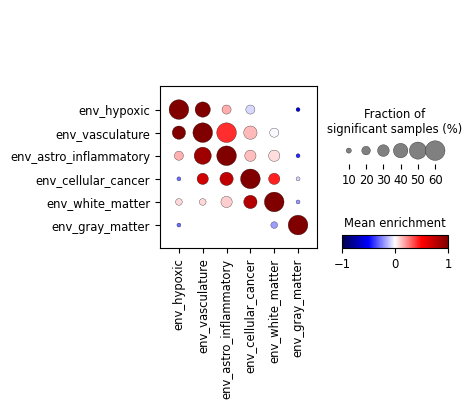

In [18]:
pthr = 1e-2
X[Padj>pthr] = 0
Xadata_df = pd.DataFrame(np.nan, index=list(patients)*len(sigs), columns=sigs+['target'])
for s in sigs:
    smatrix = X.xs(s, level=0).T.melt()
    smatrix.index = list(patients)*len(sigs)
    Xadata_df[s] = smatrix['value']
    Xadata_df['target'] = smatrix['variable']

sigs_sorted = np.array(['env_hypoxic','env_vasculature','env_astro_inflammatory','env_cellular_cancer','env_white_matter',\
              'env_gray_matter'])

Xadata = anndata.AnnData(X=Xadata_df.iloc[:,:-1],\
                         obs=Xadata_df['target'].to_frame(),\
                         var=Xadata_df.columns[:-1].to_frame())
Xadata.obs['target'] = Xadata.obs['target'].astype('category')
Xadata.obs['target'] = Xadata.obs['target'].cat.reorder_categories(sigs_sorted)

sc.pl.dotplot(Xadata, sigs_sorted, groupby='target', vmin=-1, vmax=1, cmap='seismic',
              dot_max=0.6, dot_min=0, \
              colorbar_title='Mean enrichment', size_title='Fraction of\nsignificant samples (%)',\
             save = '_spatial_enrichment_r%i_env.pdf'%r)

In [13]:
Xagg = pd.DataFrame(0, index= X.index, columns=['enrichment','n_samples_significant'])
Xagg.loc[:,'enrichment'] = X[X!=0].median(axis=1)
Xagg.loc[:,'n_samples_significant'] = (Padj[X>0]<pthr).sum(axis=1)/(Padj!=np.nan).sum(axis=1)

Xagg.to_csv('spatial_enrichment_by_regression_r%i_significant_env.csv'%r)